### Necessary libraries

In [5]:
import os
import sys
import time
import numpy
import warnings
import numpy as np
import pandas as pd
import seaborn as sb
from joblib import dump, load
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, train_test_split

### Paths

In [2]:
#REPOSITORY PATH OF PROJECT
PATH_DEV_CLEAN = os.getcwd()
(PATH_DEV,_) = os.path.split(os.getcwd())
PATH_PROJECT,y = os.path.split(PATH_DEV)
PATH_DATA = os.path.join(PATH_PROJECT,'Data')
PATH_DATA_CBIRH = os.path.join(PATH_DATA,'DATA_CBIRH_1')
PATH_DATA_CSV = os.path.join(PATH_DATA,'Data_csv\All descriptors')

LIST_CLASS = os.listdir(PATH_DATA_CBIRH)
print(os.listdir(PATH_DATA_CSV))

['DF_ALL.csv', 'Model_RF.joblib', 'Testset.joblib', 'Trainset.joblib']


### Methods

In [3]:
#tuning hyperparameter of model   
def hyperparameter_tuning_randomforestClassifier(xtrain,ytrain,xtest,ytest):
    start = time.time()
    rfc=RandomForestClassifier(bootstrap = False)   
    param_grid = {  'n_estimators': list(np.arange(100, 1000, 100)),
                'criterion' :['gini', 'entropy'],
                'max_depth' : np.arange(3, 10, 2),
                'min_samples_split' : np.arange(2, 10, 2),
                'max_features': ['auto', 'sqrt', 'log2', None],
                'bootstrap': [True, False]
             }
    kf = KFold(n_splits=5, random_state = 0, shuffle = True)
    randomizedsearch = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid,n_iter = 150,
                                          scoring='accuracy', cv= kf)
    randomizedsearch.fit(xtrain, ytrain)
    end = time.time()
    run_time = end - start
    print("[INFO] Applying took {:.2f} min".format(run_time/60))
    return randomizedsearch

#plot confusion matrix
def plot_confusion_catrix(cm):
    
    sb.set(rc={'figure.figsize':(8,8)})
    sb.set(font_scale=1.4)#for label size
    ax = sb.heatmap(cm, annot=True, cmap ='Oranges', cbar=False)
    ax.set_title('Confusion Matrix with labels\n')
    ax.set_xlabel('\nPredicted Label')
    ax.set_ylabel('\nTrue Label ')
    _= ax.xaxis.set_ticklabels(['CAR','DOG','FRUIT','PERSON','CAT'])
    _= ax.yaxis.set_ticklabels(['CAR','DOG','FRUIT','PERSON','CAT'])
#evaluate of result
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    errors = 1-accuracy
    Confusion_Matrix = confusion_matrix(test_labels, predictions)
    print('Model Performance')
    print('Average Error: {:0.2f} %.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('Classification_report :\n',classification_report(test_labels,predictions))
    print('Confusion_Matrix : \n')
    plot_confusion_catrix(Confusion_Matrix)

    
def split_data(DF):
    y =  y=DF[DF.columns[-1]] 
    del DF[DF.columns[-1]]
    X = DF
    return X,y
def read_data(path):
    DF = pd.read_csv(path)
    DF = DF.iloc[:,1::]
    return DF

### Import Model + Trainset + Testset + Data All

In [34]:
clf = load(PATH_DATA_CSV+"\Model_RF.joblib")
df = read_data(PATH_DATA_CSV+"\DF_ALL.csv")
Trainset = load(PATH_DATA_CSV+"\Trainset.joblib") 
Testset = load(PATH_DATA_CSV+"\Testset.joblib") 

### Split Data

In [35]:
Xtrain,ytrain = split_data(Trainset)
Xtest, ytest = split_data(Testset)
X,y = split_data(df)

In [36]:
Xtrain_corr = Xtrain.copy()
Xtest_corr = Xtest.copy()
X_copy=X.copy()

### Corrélation

In [37]:
correlation_matrix = X.corr(method='pearson')

In [38]:
correlated_features = set()

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            
            colname = correlation_matrix.columns[i]
            
            correlated_features.add(colname)

In [40]:
#X.drop(labels=correlated_features, axis=1, inplace=True)
Xtrain_corr.drop(labels=correlated_features, axis=1, inplace=True)
Xtest_corr.drop(labels=correlated_features, axis=1, inplace=True)

In [51]:
print("[INFO] Nombre total de caractéristiques  = {} ".format(X.shape[1]))
print("[INFO] Nombre de caractéristiques corrélées = {} ".format(len(correlated_features)))
print("[INFO] Nombre de caractéristiques non corrélées = {} ".format(Xtrain_corr.shape[1]))

[INFO] Nombre total de caractéristiques  = 511 
[INFO] Nombre de caractéristiques corrélées = 181 
[INFO] Nombre de caractéristiques non corrélées = 330 


### Model without Correlation

In [52]:
kf = KFold(n_splits=5, random_state = 0, shuffle = True)
start = time.time()
mean_all = cross_val_score(clf, Xtrain, ytrain, cv=kf, scoring = 'accuracy').mean()
end = time.time()
run_time_all = (end - start)
print("[INFO] Applying took {:.2f} min".format(run_time_all/60))
print("[INFO] Accuracy {:.2f} %".format(mean_all*100))

[INFO] Applying took 0.03 min
[INFO] Accuracy 76.80 %


[INFO] Applying took 0.01 min
Model Performance
Average Error: 0.18 %.
Accuracy = 0.82%.
Classification_report :
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       0.92      0.96      0.94        25
           2       0.64      0.54      0.58        26
           3       0.84      0.96      0.90        28
           4       0.68      0.62      0.65        24

    accuracy                           0.82       125
   macro avg       0.81      0.82      0.81       125
weighted avg       0.81      0.82      0.81       125

Confusion_Matrix : 



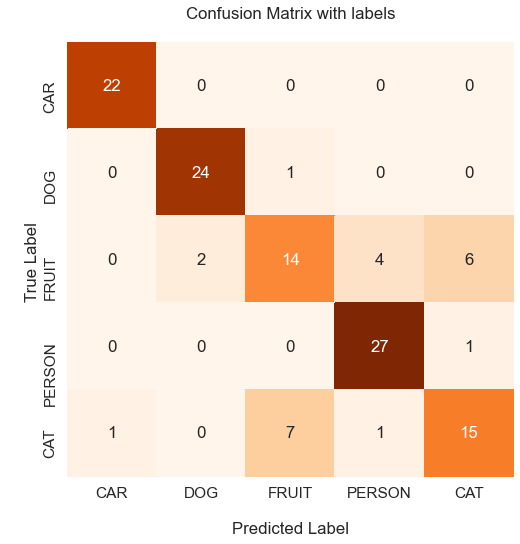

In [19]:
start = time.time()
model =clf.fit(Xtrain,ytrain)
end = time.time()
run_time_all = (end - start)
print("[INFO] Applying took {:.2f} min".format(run_time_all/60))
evaluate(model,Xtest, ytest)

### Model with correlation 

In [43]:
#Chercher les meilleurs parammetres pouyr le modèle randomforest
randomizedsearch_corr = hyperparameter_tuning_randomforestClassifier(Xtrain_corr,ytrain, Xtest_corr, ytest)

[INFO] Applying took 70.56 min


In [45]:
clf_corr = randomizedsearch_corr.best_estimator_

In [48]:
kf = KFold(n_splits=5, random_state = 0, shuffle = True)
start = time.time()
mean_all = cross_val_score(clf_corr, Xtrain_corr, ytrain, cv=kf, scoring = 'accuracy').mean()
end = time.time()
run_time_all = (end - start)
print("[INFO] Applying took {:.2f} min".format(run_time_all/60))
print("[INFO] Accuracy {:.2f} %".format(mean_all*100))

[INFO] Applying took 0.12 min
[INFO] Accuracy 73.33 %


[INFO] Applying took 0.03 min
Model Performance
Average Error: 0.26 %.
Accuracy = 0.74%.
Classification_report :
               precision    recall  f1-score   support

           0       0.88      0.95      0.91        22
           1       0.88      0.84      0.86        25
           2       0.55      0.62      0.58        26
           3       0.78      0.89      0.83        28
           4       0.62      0.42      0.50        24

    accuracy                           0.74       125
   macro avg       0.74      0.74      0.74       125
weighted avg       0.74      0.74      0.74       125

Confusion_Matrix : 



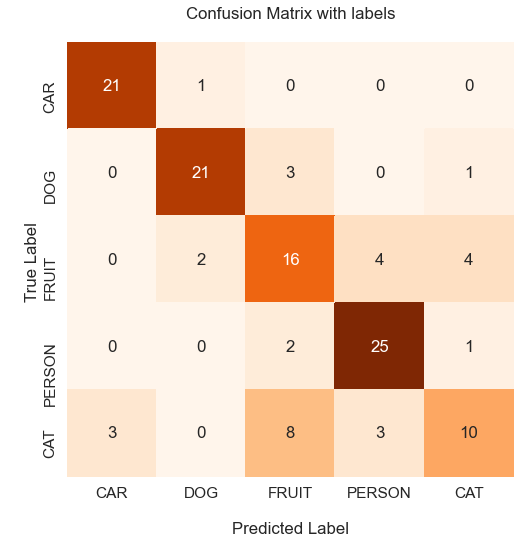

In [55]:
start = time.time()
model =clf_corr.fit(Xtrain_corr,ytrain)
end = time.time()
run_time_all = (end - start)
print("[INFO] Applying took {:.2f} min".format(run_time_all/60))
evaluate(model,Xtest_corr, ytest)